In [9]:
import os, sys, subprocess, pickle
import numpy as np
import pandas as pd
import xarray as xr
import pickle
import matplotlib.pyplot as plt

# import MO-ASMO functions
# path_MOASMO = '/glade/u/home/guoqiang/model_sources/MO-ASMO/src'
path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import sampling
import gp
import NSGA2

sys.path.append('../MOASMO_support/')
from MOASMO_parameters import *

In [35]:
param_filelist = ['/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv']
metric_filelist = ['/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/ctsm_outputs/iter0_all_metric.csv']
param_infofile = '/glade/work/guoqiang/CTSM_CAMELS/data_paramcailb/ParamCalib_1013500.csv'
outpath = '/glade/derecho/scratch/guoqiang'
iterflag = 0

In [2]:


# define hyper parameters
pop = 100
gen = 100
crossover_rate = 0.9
mu = 20
mum = 20

# define hyperparameter
alpha = 1e-3
leng_lb = 1e-3
leng_ub = 1e3
nu = 2.5

n_sample = 20 # number of selected optimal points

# input data x (parameter sets) and output data y (objective function values)
df_param = pd.concat(map(pd.read_csv, param_filelist))
df_metric = pd.concat(map(pd.read_csv, metric_filelist))
df_info = read_parameter_csv(param_infofile)

param_names = df_info['Parameter'].values # exclude binded parameters
df_param = df_param[param_names]

xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])

x = df_param.to_numpy()
y = df_metric.to_numpy()

ind = ~np.isnan( np.sum(x,axis=1) + np.sum(y,axis=1))
x, y = x[ind, :], y[ind, :]

nInput = x.shape[1]
nOutput = y.shape[1]



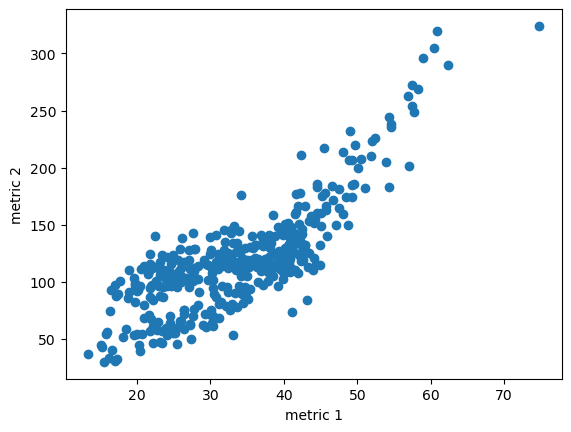

In [29]:
# plot metrics

# plt.scatter(df_metric['metric1'].values, df_metric['metric2'].values)
plt.scatter(y[:,0], y[:,1])
plt.xlabel('metric 1')
plt.ylabel('metric 2')
plt.show()

In [32]:
# # plot upper/lower bounds
# plt.plot(xlb_mean)
# plt.plot(xub_mean)
# plt.show()

In [36]:
# train the surrogate model
# https://github.com/NCAR/ctsm_optz/blob/89e3689e73180574c62d1f5aa555a57e886a7cec/workflow/scripts/MOASMO_onestep.pe_basin.py#LL311C1-L315C41
sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)
os.makedirs(outpath, exist_ok=True)
sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
pickle.dump(sm, open(sm_filename, 'wb'))

# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# sm = RandomForestRegressor()
# sm.fit(x, y)
# os.makedirs(outpath, exist_ok=True)
# sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
# pickle.dump(sm, open(sm_filename, 'wb'))


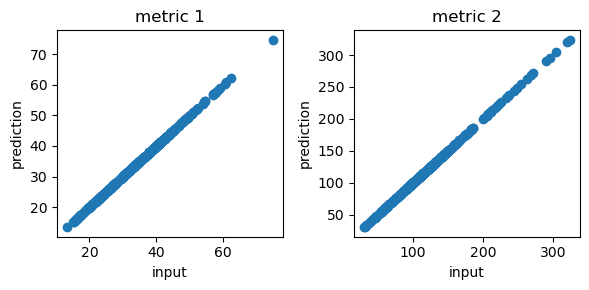

In [40]:
# check surrogate model results
y_predict = sm.predict(x)

fig = plt.figure(figsize=[6, 3])

fig.add_subplot(1,2,1)
plt.scatter(y[:,0], y_predict[:,0])
plt.title('metric 1')
plt.xlabel('input')
plt.ylabel('prediction')

fig.add_subplot(1,2,2)
plt.scatter(y[:,1], y_predict[:,1])
plt.title('metric 2')
plt.xlabel('input')
plt.ylabel('prediction')

plt.tight_layout()
plt.show()

In [ ]:


# perform optimization using the surrogate model
bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
D = NSGA2.crowding_distance(besty_sm)
idxr = D.argsort()[::-1][:n_sample]
x_resample = bestx_sm[idxr, :]
y_resample = besty_sm[idxr, :]
# y_resample = sm.predict(x_resample)

# # plot
# import matplotlib.pyplot as plt
# plt.scatter(y[:, 0], y[:, 1])
# plt.scatter(besty_sm[:, 0], besty_sm[:, 1])
# plt.scatter(besty_sm[idxr, 0], besty_sm[idxr, 1])

param_upper_bound = df_info['Upper'].values
param_lower_bound = df_info['Lower'].values
param_upper_bound_mean = np.array([np.nanmean(p) for p in param_upper_bound])
param_lower_bound_mean = np.array([np.nanmean(p) for p in param_lower_bound])

# load default parameter dataframe (file will be saved after first generation)
df_defaultparam = read_save_load_all_default_parameters(param_filelist, outpath, path_CTSM_case)
param0 = df_defaultparam['Value'].values